In [1]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
import sys
sys.path.append('../')
from Util import loadBeerRaw,loadWine,runNNs
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adagrad
from nolearn.lasagne import NeuralNet
from sklearn.metrics import accuracy_score
import time

X_train, X_test, y_train, y_test= loadBeerRaw()
encoder = LabelEncoder()
X_train['SugarScale'] = encoder.fit_transform(X_train['SugarScale']).astype(np.int32)
X_train=X_train[['OG','FG','ABV','IBU','Color','BoilSize','BoilTime','Efficiency','SugarScale','StyleID']]
X_test['SugarScale'] = encoder.fit_transform(X_test['SugarScale']).astype(np.int32)
X_test=X_test[['OG','FG','ABV','IBU','Color','BoilSize','BoilTime','Efficiency','SugarScale','StyleID']]
transformer = GaussianRandomProjection(n_components=3)
transformer.fit(X_train)
rpComponents = transformer.transform(X_train)
X_train = pd.DataFrame(data = rpComponents,index=X_train.index
             , columns = ['RP component 1', 'RP component 2','RP component 3'])
rpComponents = transformer.transform(X_test)
X_test = pd.DataFrame(data = rpComponents,index=X_test.index
             , columns = ['RP component 1', 'RP component 2','RP component 3'])


y_test =encoder.fit_transform(y_test).astype(np.int32)
y_train=encoder.fit_transform(y_train).astype(np.int32)
num_features = X_train.shape[1]
num_classes = len(encoder.classes_)
X_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,RP component 1,RP component 2,RP component 3
BeerID,,,
53355,-41.560899,89.949537,26.041389
65753,-45.503350,89.476035,43.620852
59953,-3.924193,89.738089,79.629250
19190,-21.893028,96.366064,24.735987
41651,-35.161706,79.551700,12.283510


In [10]:
def runNNs(X_train, X_test, y_train, y_test,num_classes,num_features,title,epochs,learningRate):
    val_auc_single_train, val_auc_single_test = np.zeros(epochs), np.zeros(epochs)
    val_auc_double_train, val_auc_double_test = np.zeros(epochs), np.zeros(epochs)
    timeTaken = []
    timeTakenRollingAvg =[]
    layers = [('input', InputLayer),
           ('dense0', DenseLayer),
           ('dropout0', DropoutLayer),
           ('output', DenseLayer)
           ]
    net1 = NeuralNet(layers=layers,
                 input_shape=(None, num_features),
                 dense0_num_units=512, 
                 dropout0_p=0.1,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 update=adagrad,
                 update_learning_rate=learningRate,
                 verbose=0,
                 eval_size=0.0,
                 max_epochs=1)
    
    for i in range(epochs):
        net1.fit(X_train, y_train)
        pred = net1.predict(X_test)
        pred = pred.astype(int)
        val_auc_single_test[i] = accuracy_score(y_test,pred)
        pred = net1.predict(X_train)
        pred = pred.astype(int)
        val_auc_single_train[i] = accuracy_score(y_train,pred) 
    
    layers = [('input', InputLayer),
           ('dense0', DenseLayer),
           ('dropout0', DropoutLayer),
           ('dense1', DenseLayer),
           ('dropout1', DropoutLayer),
           ('output', DenseLayer)
           ]
    net2 = NeuralNet(layers=layers,
                 input_shape=(None, num_features),
                 dense0_num_units=512, 
                 dropout0_p=0.1,
                 dense1_num_units=256,
                 dropout1_p=0.1,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 update=adagrad,
                 update_learning_rate=learningRate,
                 eval_size=0.0,
                 verbose=0,
                 max_epochs=1)
    for i in range(epochs):
        net2.fit(X_train, y_train)
        pred = net2.predict(X_test)
        pred = pred.astype(int)
        val_auc_double_test[i] = accuracy_score(y_test,pred)
        pred = net2.predict(X_train)
        pred = pred.astype(int)
        val_auc_double_train[i] = accuracy_score(y_train,pred)
        
    plt.plot(val_auc_single_test, label="Test Set : Single layer")
    plt.plot(val_auc_single_train,label="Train Set : Single layer")
    plt.plot(val_auc_double_train, label="Train Set : Two layer")
    plt.plot(val_auc_double_test, label="Test Set : Two layer")
    plt.legend(loc='lower right')
    plt.xlabel("Epochs (Back Propagation Loop)")
    plt.ylabel("Percent Correct")
    plt.title(title+str(learningRate))
    plt.savefig("../plots/RP/EM/neuralnet/"+title+str(learningRate)+".png")
    plt.show()

In [11]:
gmm = GaussianMixture(n_components=8)
gmm.fit(X_train)
y_gmm = gmm.predict(X_train)
# with Clusters
X_train_with_Cluster=X_train.copy()
X_train_with_Cluster["Cluster"] = y_gmm

In [12]:
y_gmm = gmm.predict(X_test)
X_test_with_Cluster=X_test.copy()
X_test_with_Cluster["Cluster"]=y_gmm

C:\ProgramData\Anaconda3\lib\site-packages\nolearn\lasagne\base.py:370: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "
C:\ProgramData\Anaconda3\lib\site-packages\nolearn\lasagne\base.py:370: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "


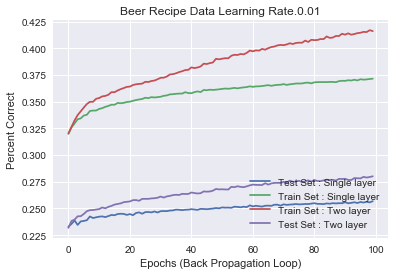

In [13]:
learningRates=[.01]
for i in learningRates:
    runNNs(X_train_with_Cluster, X_test_with_Cluster, y_train, y_test,num_classes,num_features+1,"Beer Recipe Data Learning Rate.",100,i)